In [1]:
!pip install transformers

import pandas as pd
import numpy as np
import tensorflow as tf
import random
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.special import softmax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.3 MB/s eta 0:00:00


In [2]:
import os
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
from transformers import TFRobertaForSequenceClassification, AutoTokenizer

# Load pre-trained RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweet_emotions.csv')
df = df.drop('tweet_id', axis=1)

emotion_map = {
    'empty': 'neutral',
    'neutral': 'neutral',
    'boredom': 'negative',
    'anger': 'negative',
    'hate': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'enthusiasm': 'positive',
    'love': 'positive',
    'happiness': 'positive',
    'relief': 'positive',
    'fun': 'positive',
    'surprise': 'positive'
}

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

df['content'] = df['content'].apply(preprocess)
df['sentiment'] = df['sentiment'].apply(lambda x: emotion_map[x])

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df = df.rename(columns={'sentiment':'label', 'content':'text'})

# Split dataset into train, validation and test sets
train_df, val_test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

In [6]:
# Concatenate augmented dataset with the original training dataset
augmented_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/paraphrased.csv')
augmented_df = augmented_df.drop(columns=['original_text'])
augmented_df['text'] = augmented_df['text'].apply(preprocess)

train_df = pd.concat([train_df, augmented_df], ignore_index=True)
train_df = train_df.sample(frac=1)
train_df['label'].value_counts()

1    12525
2    12286
0    12189
Name: label, dtype: int64

In [7]:
# Preprocess the text data using the tokenizer
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Create TensorFlow datasets from the preprocessed data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['label'].values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_df['label'].values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['label'].values
))

In [8]:
from transformers import RobertaConfig, RobertaModel

num_labels = len(df['label'].unique())

id2label = {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  }
  
label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  }

# Initializing a RoBERTa configuration
configuration = RobertaConfig.from_pretrained(
    model_name, 
    architectures='TFRobertaForSequenceClassification',
    attention_probs_dropout_prob=0.2, 
    classifier_dropout=0.15, 
    hidden_dropout_prob=0.2,
    num_labels=num_labels, 
    id2label=id2label, 
    label2id=label2id,
    )

In [26]:
# Custom loss function for the neutral label threshold
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.from_logits = from_logits
        self.threshold = threshold

    def call(self, y_true, y_pred):
        neutral_scale = tf.where(y_pred[:, 1] > self.threshold, 1.0, 0.0)
        neutral_scale = tf.expand_dims(neutral_scale, axis=-1)
        y_pred = y_pred * tf.one_hot(1, depth=3) * neutral_scale + y_pred * (1 - tf.one_hot(1, depth=3))
        return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)

with strategy.scope():
  model = TFRobertaForSequenceClassification.from_pretrained(model_name, config=configuration)

  # Define optimizer, loss function, and metrics 
  optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=0.001)
  loss = CustomSparseCategoricalCrossentropy(from_logits=True, threshold=0.5)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Compile the model with the custom activation function
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 0,
  "classifier_dropout": 0.15,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [28]:
history = model.fit(train_dataset.batch(256), epochs=15, batch_size=256, validation_data=val_dataset.batch(256), callbacks=[early_stop])

Epoch 1/15
145/145 [==============================] - 188s 622ms/step - loss: 0.9335 - accuracy: 0.5508 - val_loss: 0.8909 - val_accuracy: 0.6097
Epoch 2/15
145/145 [==============================] - 31s 213ms/step - loss: 0.7770 - accuracy: 0.6652 - val_loss: 0.8872 - val_accuracy: 0.6240
Epoch 3/15
145/145 [==============================] - 30s 204ms/step - loss: 0.7457 - accuracy: 0.6821 - val_loss: 0.8935 - val_accuracy: 0.6270
Epoch 4/15
145/145 [==============================] - 29s 203ms/step - loss: 0.7303 - accuracy: 0.6875 - val_loss: 0.8981 - val_accuracy: 0.6327
Epoch 5/15
145/145 [==============================] - 33s 227ms/step - loss: 0.7146 - accuracy: 0.6977 - val_loss: 0.8821 - val_accuracy: 0.6345
Epoch 6/15
145/145 [==============================] - 30s 203ms/step - loss: 0.7042 - accuracy: 0.7006 - val_loss: 0.8883 - val_accuracy: 0.6360
Epoch 7/15
145/145 [==============================] - 29s 202ms/step - loss: 0.6913 - accuracy: 0.7072 - val_loss: 0.8921 - val_a

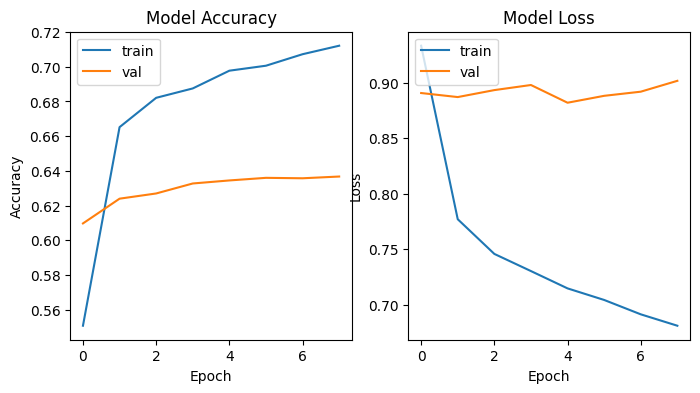

In [29]:
# Create a figure object with two subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='upper left')

# Plot loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# Display the figure
plt.show()

63/63 [==============================] - 18s 192ms/step


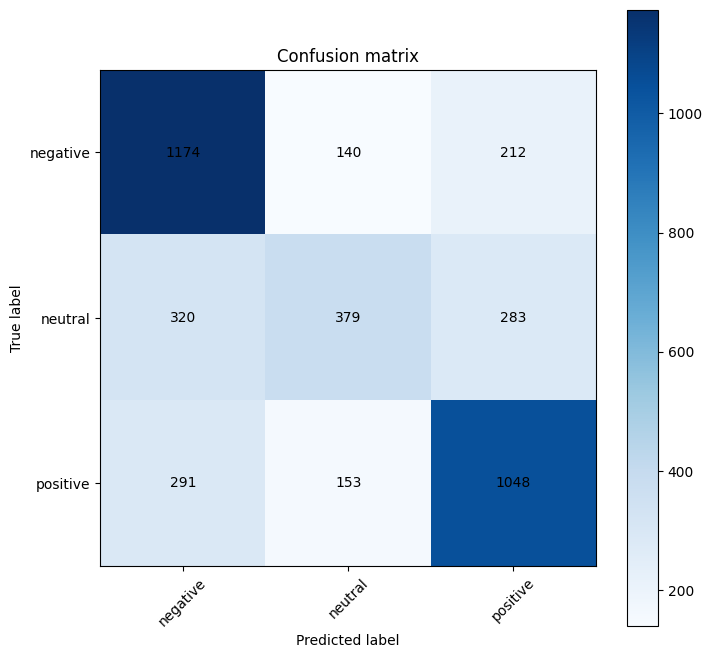

Accuracy: 0.65025
Precision: [0.65770308 0.5639881  0.67919637]
Recall: [0.76933159 0.38594705 0.70241287]
F1 score: [0.70915131 0.45828295 0.69060956]


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

classes = ['negative', 'neutral', 'positive']

# Get the predicted labels for the validation data
y_pred = model.predict(test_dataset.batch(64))

# Convert predicted probabilities to labels
y_pred_logits = y_pred.logits.tolist()
y_pred_labels = np.argmax(y_pred_logits, axis=1)

# Get the true labels for the validation data
y_true = test_df['label'].values

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues, extent=[-0.5, len(classes)-0.5, len(classes)-0.5, -0.5])
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels, average=None)
recall = recall_score(y_true, y_pred_labels, average=None)
f1 = f1_score(y_true, y_pred_labels, average=None)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [14]:
from huggingface_hub import notebook_login, push_to_hub_keras

notebook_login() 

In [31]:
model.push_to_hub("leonong84/roberta-tuned-v2")
tokenizer.push_to_hub("leonong84/roberta-tuned-v2")
model.save_pretrained("leonong84/roberta-tuned-v2", push_to_hub=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [32]:
from transformers import pipeline

pipe = pipeline(model="leonong84/roberta-tuned-v2", tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at leonong84/roberta-tuned-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


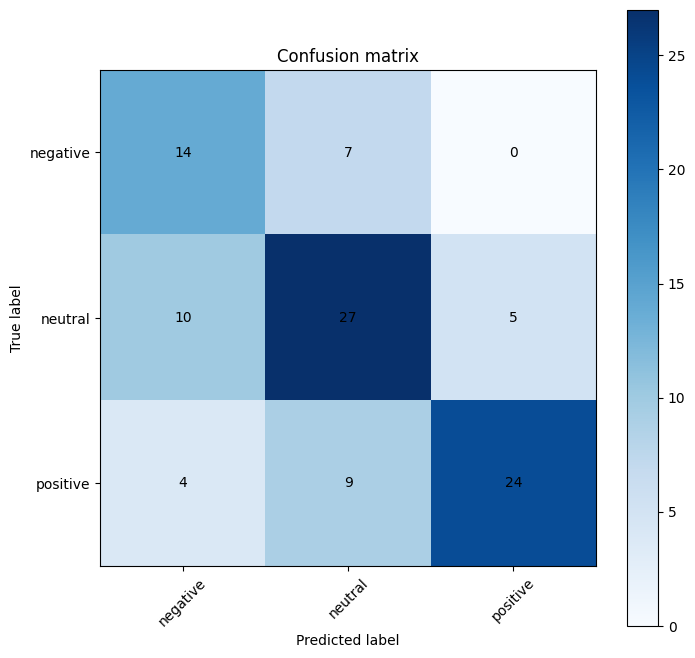

Accuracy: 0.65
Precision: [0.5        0.62790698 0.82758621]
Recall: [0.66666667 0.64285714 0.64864865]
F1 score: [0.57142857 0.63529412 0.72727273]


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

classes = ['negative', 'neutral', 'positive']

# Load dataset
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_data = test_data.rename(columns={'sentiment':'label', 'content':'text'})
test_data = test_data.sample(n=100, random_state=23)

# Preprocess
test_data['text'] = test_data['text'].apply(preprocess)

# Make predictions using the pipeline
predictions = pipe(list(test_data['text']))

# Convert predicted labels to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
predicted_labels = [label_map[prediction['label']] for prediction in predictions]

# Get true labels as integers
true_labels = list(test_data['label'])

# Compute the confusion matrix
test_cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(test_cm, cmap=plt.cm.Blues, extent=[-0.5, len(classes)-0.5, len(classes)-0.5, -0.5])
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, test_cm[i, j], ha='center', va='center', color='black')

plt.show()

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)